In [22]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.tree import plot_tree

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

import matplotlib.pyplot as plt
import seaborn as sns
import polars as pl
import numpy as np
import os

DATA_PATH = "./data/pet_store_records_2020.csv"

# Read data

In [3]:
datasheet = pl.read_csv(DATA_PATH, has_header=True, separator=",")

In [4]:
datasheet = datasheet.drop(['vendor_id', 'VAP', 'country', 'pet_size'])
datasheet.head()

product_id,product_category,sales,price,pet_type,rating,re_buy
i64,str,i64,i64,str,i64,i64
5040,"""Equipment""",123,7293,"""fish""",7,1
4567,"""Toys""",61,9304,"""cat""",10,0
4237,"""Toys""",218,8180,"""hamster""",6,0
4364,"""Snack""",69,18559,"""dog""",1,1
4184,"""Supplements""",138,10283,"""dog""",10,0


In [5]:
datasheet.schema

{'product_id': Int64,
 'product_category': Utf8,
 'sales': Int64,
 'price': Int64,
 'pet_type': Utf8,
 'rating': Int64,
 're_buy': Int64}

### Plotting for analysis

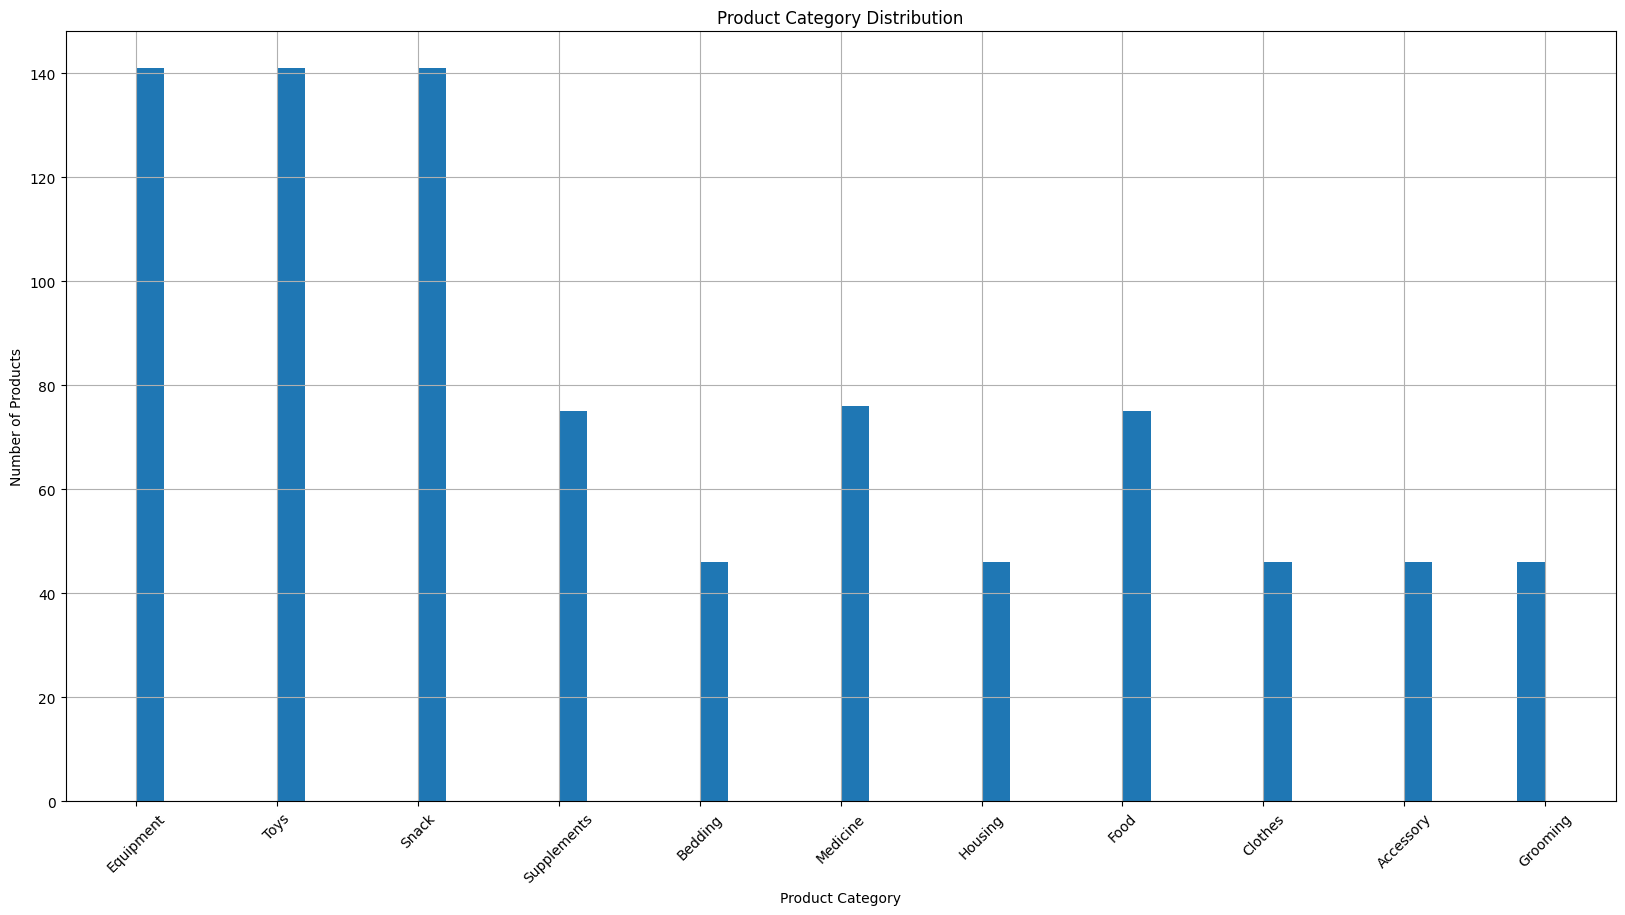

In [6]:
plt.figure(figsize=(20, 10))
plt.hist(datasheet['product_category'], bins=50)
plt.grid()
plt.xlabel('Product Category')
plt.ylabel('Number of Products')
plt.title('Product Category Distribution')
plt.xticks(rotation=45)
plt.show()

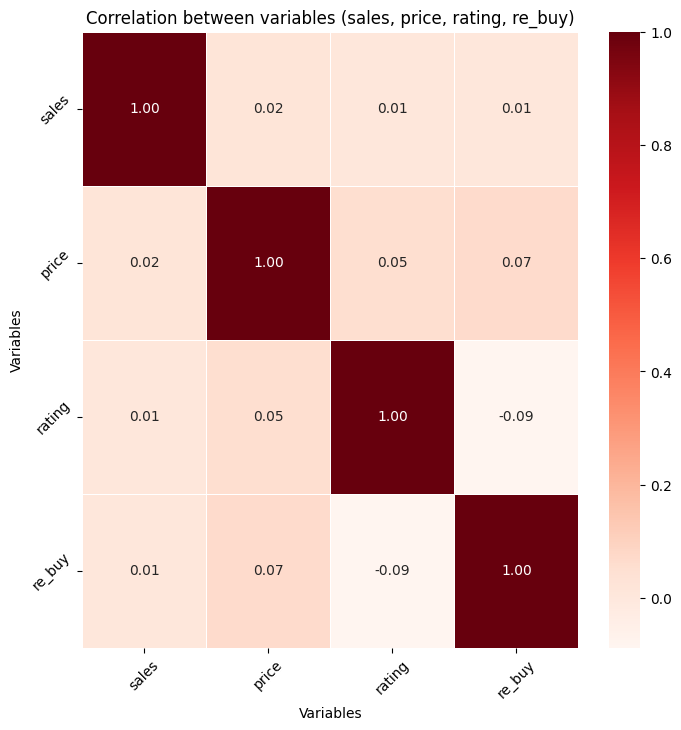

In [7]:
relationship = datasheet[["sales", "price", "rating", "re_buy"]].corr()

plt.figure(figsize=(8, 8))
sns.heatmap(relationship, annot=True, fmt=".2f", linewidths=.5, cmap='Reds')
plt.title("Correlation between variables (sales, price, rating, re_buy)")
plt.xlabel("Variables")
plt.ylabel("Variables")
plt.xticks([0.5, 1.5, 2.5, 3.5], ["sales", "price", "rating", "re_buy"], rotation=45)
plt.yticks([0.5, 1.5, 2.5, 3.5], ["sales", "price", "rating", "re_buy"], rotation=45)
plt.show()

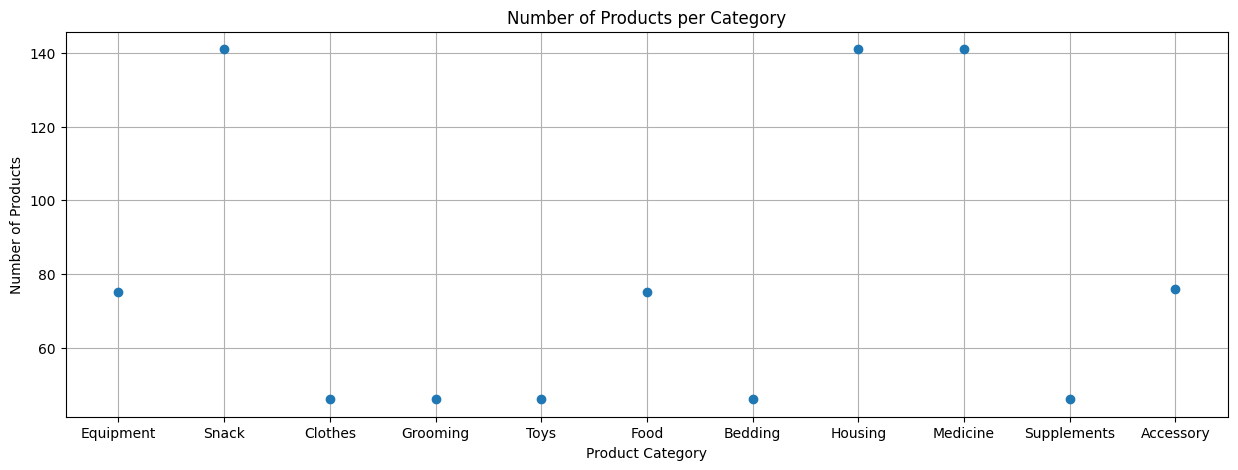

In [8]:
plt.figure(figsize=(15, 5))
plt.plot(datasheet['product_category'].value_counts()[:, 0], datasheet['product_category'].value_counts()[:, 1], linestyle='none', marker='o')
plt.xlabel('Product Category')
plt.ylabel('Number of Products')
plt.title('Number of Products per Category')
plt.grid(True)
plt.show()

# Pre-processing

In [9]:
product_category = datasheet['product_category'].unique()
grouped_category_target = {
    'Food': ['Food', 'Supplements', 'Snack'],
    'Medicine': ['Medicine'],
    'Housing': ['Housing', 'Equipment', 'Bedding'],
    'Clothing': ['Clothes', 'Accessory'],
    'Gromming': ['Grooming', 'Toys']
}

def get_category(category):
    for key, value in grouped_category_target.items():
        if category in value:   return key
    print(f'Unknown category: {category}')
    return 'Others'

datasheet.replace('product_category', datasheet['product_category'].apply(get_category))

product_id,product_category,sales,price,pet_type,rating,re_buy
i64,str,i64,i64,str,i64,i64
5040,"""Housing""",123,7293,"""fish""",7,1
4567,"""Gromming""",61,9304,"""cat""",10,0
4237,"""Gromming""",218,8180,"""hamster""",6,0
4364,"""Food""",69,18559,"""dog""",1,1
4184,"""Food""",138,10283,"""dog""",10,0
4609,"""Housing""",183,3969,"""cat""",10,0
4380,"""Gromming""",79,13519,"""dog""",8,0
4389,"""Housing""",205,13078,"""cat""",9,0
4697,"""Food""",116,13701,"""cat""",10,0


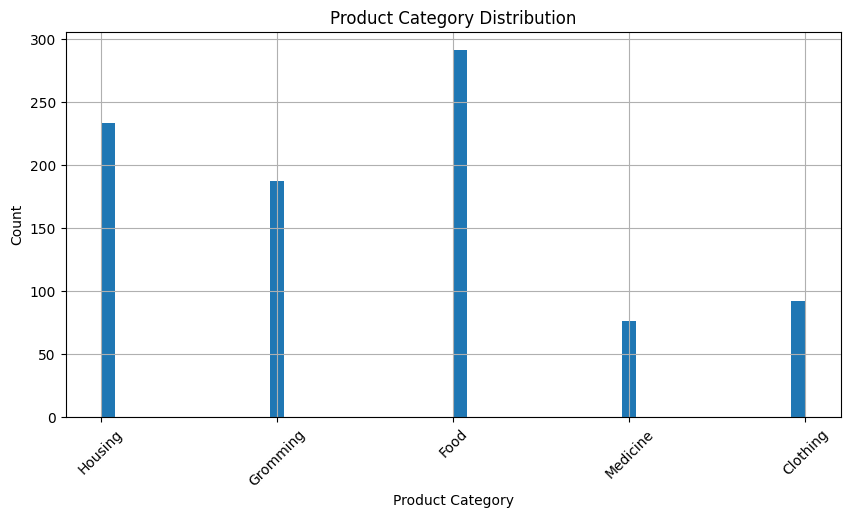

In [12]:
plt.figure(figsize=(10, 5))
plt.hist(datasheet['product_category'], bins=50)
plt.xticks(rotation=45)
plt.title('Product Category Distribution')
plt.xlabel('Product Category')
plt.ylabel('Count')
plt.grid()
plt.show()

In [13]:
org_product_category = datasheet['product_category'].to_list()
product_category_uni = datasheet['product_category'].unique().sort()
product_category_uni_code = [i for i in range(len(product_category_uni))]
for i in range(len(product_category_uni)):  print(f"[{product_category_uni[i]}]\t->\t[{product_category_uni_code[i]}]")

product_category = []
for i in range(len(org_product_category)):
    for j in range(len(product_category_uni)):
        if org_product_category[i] == product_category_uni[j]:
            product_category.append(product_category_uni_code[j])

product_category = pl.Series(product_category)
datasheet.replace('product_category', product_category)

[Clothing]	->	[0]
[Food]	->	[1]
[Gromming]	->	[2]
[Housing]	->	[3]
[Medicine]	->	[4]


product_id,product_category,sales,price,pet_type,rating,re_buy
i64,i64,i64,i64,str,i64,i64
5040,3,123,7293,"""fish""",7,1
4567,2,61,9304,"""cat""",10,0
4237,2,218,8180,"""hamster""",6,0
4364,1,69,18559,"""dog""",1,1
4184,1,138,10283,"""dog""",10,0
4609,3,183,3969,"""cat""",10,0
4380,2,79,13519,"""dog""",8,0
4389,3,205,13078,"""cat""",9,0
4697,1,116,13701,"""cat""",10,0


In [14]:
org_pet_type = datasheet['pet_type'].to_list()
pet_type_uni = datasheet['pet_type'].unique().sort()
pet_type_uni_code = [i for i in range(len(pet_type_uni))]
for i in range(len(pet_type_uni)):  print(f"[{pet_type_uni_code[i]}]\t->\t{pet_type_uni[i]}")

pet_type = []
for i in range(len(org_pet_type)):
    for j in range(len(pet_type_uni)):
        if org_pet_type[i] == pet_type_uni[j]:
            pet_type.append(pet_type_uni_code[j])
    
pet_type = pl.Series(pet_type)
datasheet.replace('pet_type', pet_type)

[0]	->	bird
[1]	->	cat
[2]	->	dog
[3]	->	fish
[4]	->	hamster
[5]	->	rabbit


product_id,product_category,sales,price,pet_type,rating,re_buy
i64,i64,i64,i64,i64,i64,i64
5040,3,123,7293,3,7,1
4567,2,61,9304,1,10,0
4237,2,218,8180,4,6,0
4364,1,69,18559,2,1,1
4184,1,138,10283,2,10,0
4609,3,183,3969,1,10,0
4380,2,79,13519,2,8,0
4389,3,205,13078,1,9,0
4697,1,116,13701,1,10,0


In [15]:
processed_datasheet = datasheet
processed_datasheet.write_parquet("./data/processed_datasheet.parquet")

# Train, Test(Validation) Split

In [16]:
y_data = datasheet['product_category'].to_numpy()
X_data = datasheet.drop(['product_category']).to_numpy()

print(f"""X_data shape: {X_data.shape}
y_data shape: {y_data.shape}""")

X_data shape: (879, 6)
y_data shape: (879,)


In [17]:
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2, random_state=42)
print(f"""X_train: {X_train.shape}
y_train: {y_train.shape}
X_test: {X_test.shape}
y_test: {y_test.shape}""")

X_train: (703, 6)
y_train: (703,)
X_test: (176, 6)
y_test: (176,)


In [18]:
classifier = RandomForestClassifier()
classifier.fit(X_train, y_train)

RandomForestClassifier()

In [19]:
y_pred = classifier.predict(X_test)

mse_loss = mean_squared_error(y_test, y_pred)
print("MSE Loss: ", mse_loss)

r2_score = r2_score(y_test, y_pred)
print("R2 Score: ", r2_score)

MSE Loss:  3.1420454545454546
R2 Score:  -1.2430457929063632


In [20]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.06      0.05      0.06        19
           1       0.20      0.27      0.23        52
           2       0.12      0.07      0.09        43
           3       0.18      0.26      0.21        43
           4       0.00      0.00      0.00        19

    accuracy                           0.16       176
   macro avg       0.11      0.13      0.12       176
weighted avg       0.14      0.16      0.15       176



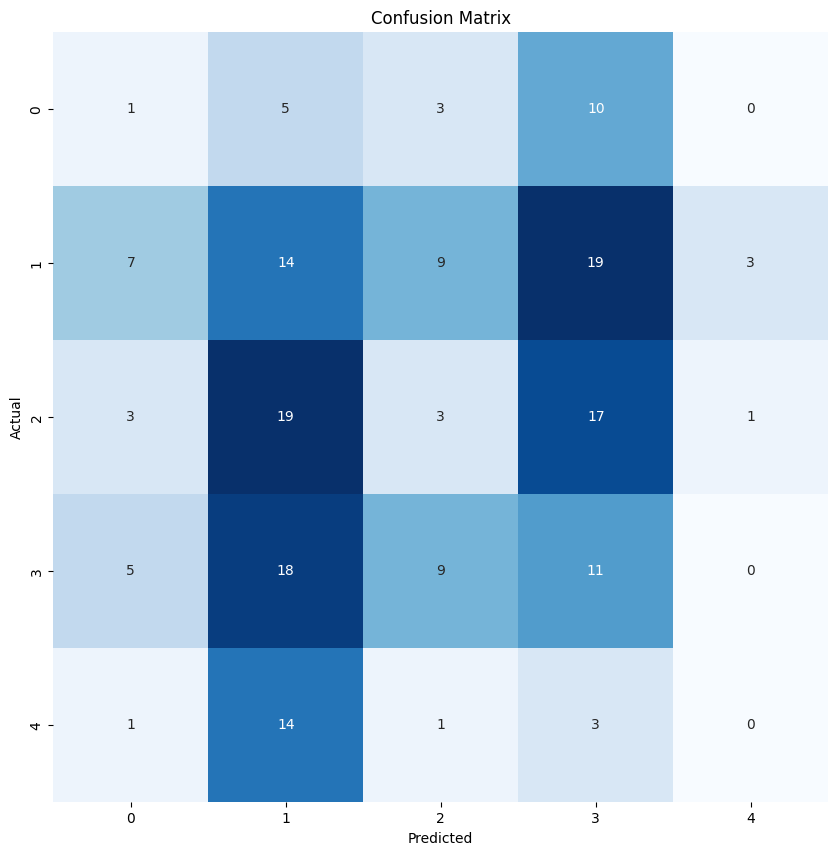

In [21]:
conf_mat = confusion_matrix(y_test, y_pred)
ticks_labels = np.unique(y_test)
ticks_labels.sort()
ticks_labels = [str(i) for i in ticks_labels]

plt.figure(figsize=(10, 10))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.xticks(ticks=np.arange(len(ticks_labels))+0.5, labels=ticks_labels)
plt.yticks(ticks=np.arange(len(ticks_labels))+0.5, labels=ticks_labels)
plt.show()